<a href="https://colab.research.google.com/github/kundajelab/locusselect/blob/master/examples/regression%20on%20200%20bp%20genome%20bins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from numpy.random import seed
seed(1234)

In [2]:
import numpy as np
from sklearn import manifold
from apricot import FacilityLocationSelection
from apricot import FeatureBasedSelection
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import umap
from sklearn.manifold import TSNE

In [3]:
from sklearn.decomposition import PCA
import seaborn as sns
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [13]:
import locusselect 
from locusselect.embeddings import * 
from locusselect.deeplift import * 
from locusselect.utils import *
import os
import pickle

In [5]:
def umap_transform(peak_data, n_components=3, random_state=25, metric = 'correlation',n_neighbors=15,min_dist=0.1):
    umap_obj = umap.UMAP(n_components=n_components, random_state=random_state,
        min_dist=min_dist,metric=metric,n_neighbors=n_neighbors)
    try:
        umap_res = umap_obj.fit_transform(peak_data.toarray())
    except:
        umap_res = umap_obj.fit_transform(peak_data)
    return umap_res

In [6]:
def performEmbeddings ( data_list, n_components=2, random_state=2, metric= 'correlation' ) :
    embedding_list = []; 
    for data in data_list :
        embedding_list.append( umap_transform(data, n_components=2, random_state=2,metric=distanceMeasure) )
    return (embedding_list)

In [7]:
def makeGeneralAnnotation ( Ind_list, label_list, k ) :
    num_labels = np.zeros(k)
    
    label_dict = { 'All' : 0 }
    for i in range(len(Ind_list)) :
        num_labels[Ind_list[i]] = i + 1
        label_dict[label_list[i]] = i + 1
    return (num_labels, label_dict)

In [8]:
#layer -2
#layer 1 -- global_average_pooling
#layer 9 

In [9]:
def plot_embedding_2d(embedding, num_labels=None, label_dict=None, s_dict=None, a_dict=None, cmap=None, norm=None, title='' ):
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)
    if num_labels is None or label_dict is None :
        scatter_res = ax.scatter(embedding[:,0], embedding[:,1], s=4, alpha=1)

    else :
        for label in label_dict.keys() :
            Ind = np.where(num_labels == label_dict[label])[0]
            color = cm.jet(label_dict[label] / float(len(label_dict.keys()) - 1))
            if s_dict is None : 
                dotsize = 4 
            else : 
                dotsize = s_dict[label]
            if a_dict is None : 
                alpha = 1
            else : 
                alpha = a_dict[label]
            scatter_res = ax.scatter(embedding[Ind,0], embedding[Ind,1], s=dotsize, alpha=alpha,c=color, label=label)
        ax.set_xlim( min(embedding[:,0]) - ( ( max(embedding[:,0]) - min(embedding[:,0]) ) * 0.5 ), max(embedding[:,0]) )
        ax.set_ylim( min(embedding[:,1]), max(embedding[:,1]) + ( ( max(embedding[:,1]) - min(embedding[:,1]) ) * 0.5 ) )
        ax.set_title(title)
        ax.legend(loc='upper left',prop={'size': 12})

In [25]:
def selectSubset ( data_matrix, n = None, distance = 'euclidean', initial_subset = None, selection_subset = None ) :
    if selection_subset is not None :
        data_matrix = data_matrix[selection_subset]
    
    if n is None :
        n = np.shape(data_matrix)[0]
    
    if initial_subset is None :
        model = FacilityLocationSelection(n, distance)
    else :
        model = FacilityLocationSelection(n, distance, initial_subset = initial_subset )
    
    Xi = model.fit_transform(data_matrix)
    SubsetInd = model.ranking
    Gains = model.gains
    
    if selection_subset is not None :
        SubsetInd = selection_subset[SubsetInd]
    
    return SubsetInd, Gains

In [10]:
def get_embedding_data_list_fc(bed_list, layer):

    dl_fc_data_list = []
    
    for bed_file in bed_list:
        
        print(bed_file)
        print(layer)
        
        all_fc_embeddings = []

        fc_embedding_args={"input_bed_file":bed_file,
                   "model_hdf5":"/data/locusselect/k562_dnase_dl_models/k562_regression/DNASE.K562.regressionlabels.allbins.0",
                   "ref_fasta":"/data/refs/hg19/male.hg19.fa",
                   "center_on_summit":True,
                   "flank":500,
                   "embedding_layer":layer,
                   "expand_dims":True,
                   "threads":20}
        fc_regions, fc_embeddings = compute_embeddings(fc_embedding_args)
        np.savez_compressed(bed_file.split('/')[-1]+'.fc.npz',bed_entries=fc_regions,fc_scores=fc_embeddings)
        
        dl_fc_data_list.append(fc_embeddings)
        
    return dl_fc_data_list

In [11]:
def get_embedding_data_list_conv(bed_list, layer):

    dl_fc_data_list = []
    
    for bed_file in bed_list:
        
        print(bed_file)
        print(layer)
        all_fc_embeddings = []

        fc_embedding_args={"input_bed_file":bed_file,
                   "model_hdf5":"/data/locusselect/k562_dnase_dl_models/k562_regression/DNASE.K562.regressionlabels.allbins.0",
                   "ref_fasta":"/data/refs/hg19/male.hg19.fa",
                   "center_on_summit":True,
                   "flank":125,
                   "embedding_layer":layer,
                   "expand_dims":True,
                   "threads":20,
                   "global_pool_on_position":True}
        fc_regions, fc_embeddings = compute_embeddings(fc_embedding_args)
        np.savez_compressed(bed_file.split('/')[-1]+'.fc.npz',bed_entries=fc_regions,fc_scores=fc_embeddings)
        
        dl_fc_data_list.append(fc_embeddings)
        
    return dl_fc_data_list

In [24]:
bed_list = ['/users/soumya.kundu/locusselect/coordinates/'+x for x in os.listdir('/users/soumya.kundu/locusselect/coordinates/') if x.endswith('bed')]
print(bed_list)

W0708 23:26:19.473908 140284742530880 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 23:26:19.487683 140284742530880 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0708 23:26:19.506679 140284742530880 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0708 23:26:19.507166 140284742530880 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0708 23:26:19.

['/users/soumya.kundu/locusselect/coordinates/coordinates_5.bed', '/users/soumya.kundu/locusselect/coordinates/coordinates_1.bed', '/users/soumya.kundu/locusselect/coordinates/coordinates_3.bed', '/users/soumya.kundu/locusselect/coordinates/coordinates_2.bed', '/users/soumya.kundu/locusselect/coordinates/coordinates_0.bed', '/users/soumya.kundu/locusselect/coordinates/coordinates_4.bed']
/users/soumya.kundu/locusselect/coordinates/coordinates_5.bed
-2


W0708 23:26:19.863022 140284742530880 deprecation.py:506] From /opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0708 23:26:20.604094 140284742530880 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0708 23:26:20.617362 140284742530880 deprecation.py:323] From /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


got model architecture
loaded model weights
loaded model
obtained embedding layer model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 1, 1000, 4)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1000, 300)      23100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 1000, 300)      1200      
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1000, 300)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 333, 300)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 333, 200)       660200    
______________________________________________________

9/9 [==============================] - 26s 3s/step
got embeddings
got region labels
/users/soumya.kundu/locusselect/coordinates/coordinates_2.bed
-2
got model architecture
loaded model weights
loaded model
obtained embedding layer model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 1, 1000, 4)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1000, 300)      23100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 1000, 300)      1200      
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1000, 300)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 333, 300)       0         
_____________________________________

9/9 [==============================] - 23s 3s/step
got embeddings
got region labels


In [ ]:
dl_fc_data_list = get_embedding_data_list_fc(bed_list, -2)

In [25]:
dl_conv_data_list = get_embedding_data_list_conv(bed_list, 1)

/users/soumya.kundu/locusselect/coordinates/coordinates_5.bed
1
got model architecture
loaded model weights
loaded model
Could not transfer weights for layer:dense_1
obtained embedding layer model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 1, 250, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 250, 300)       23100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 250, 300)       1200      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 300)               0         
Total params: 24,300
Trainable params: 23,700
Non-trainable params: 600
_________________________________________________________________
None
created data generator
9/9 [==============================] - 7s 7

In [12]:
#with open('dl_conv_data_list.pickle', 'wb') as fp:
#    pickle.dump(dl_conv_data_list, fp)

#with open('dl_fc_data_list.pickle', 'wb') as fp:
#    pickle.dump(dl_fc_data_list, fp)

"\nwith open('dl_conv_data_list.pickle', 'wb') as fp:\n    pickle.dump(dl_conv_data_list, fp)\n\nwith open('dl_fc_data_list.pickle', 'wb') as fp:\n    pickle.dump(dl_fc_data_list, fp)\n"

In [14]:
with open ('dl_conv_data_list.pickle', 'rb') as fp:
    dl_conv_data_list = pickle.load(fp)
    
with open ('dl_fc_data_list.pickle', 'rb') as fp:
    dl_fc_data_list = pickle.load(fp)

In [15]:
distanceMeasure = 'correlation'
dl_conv_embedding_list = performEmbeddings(dl_conv_data_list,metric=distanceMeasure)
dl_fc_embedding_list = performEmbeddings(dl_fc_data_list,metric=distanceMeasure)

In [16]:
#with open('dl_conv_embedding_list.pickle', 'wb') as fp:
#    pickle.dump(dl_conv_embedding_list, fp)

#with open('dl_fc_embedding_list.pickle', 'wb') as fp:
#    pickle.dump(dl_fc_embedding_list, fp)

In [ ]:
with open ('dl_conv_embedding_list.pickle', 'rb') as fp:
    dl_conv_embedding_list = pickle.load(fp)
    
with open ('dl_fc_embedding_list.pickle', 'rb') as fp:
    dl_fc_embedding_list = pickle.load(fp)

/users/soumya.kundu/locusselect/coordinates/coordinates_5.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_1.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_3.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_2.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_0.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_4.bed


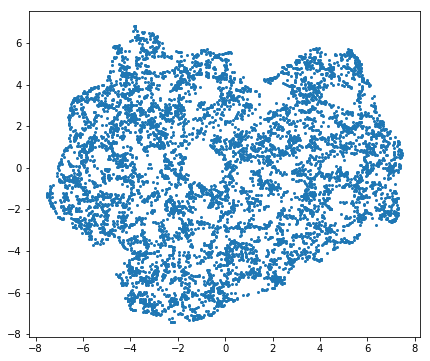

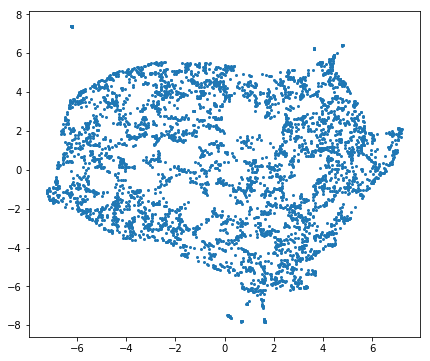

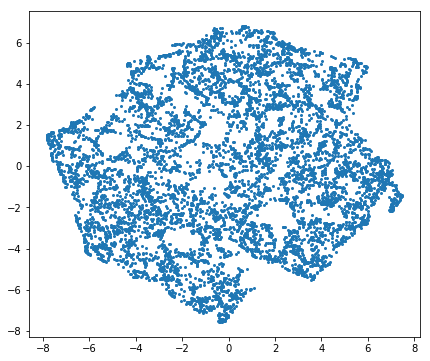

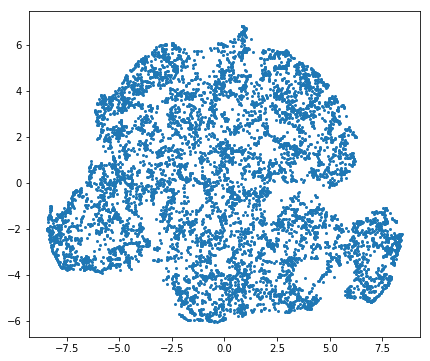

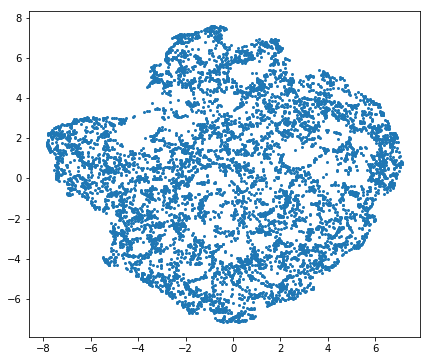

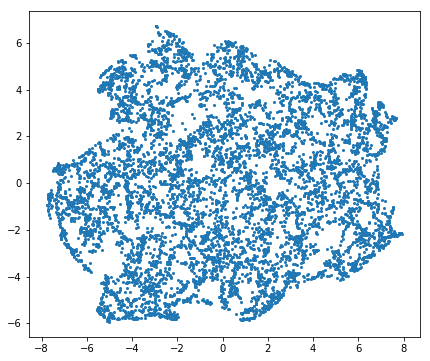

In [22]:
for embedding, file_ in zip(dl_conv_embedding_list, bed_list):
    print(file_)
    plot_embedding_2d(embedding)

/users/soumya.kundu/locusselect/coordinates/coordinates_5.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_1.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_3.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_2.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_0.bed
/users/soumya.kundu/locusselect/coordinates/coordinates_4.bed


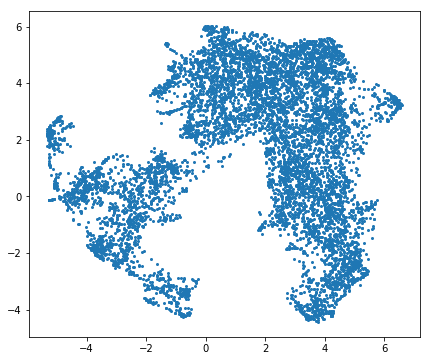

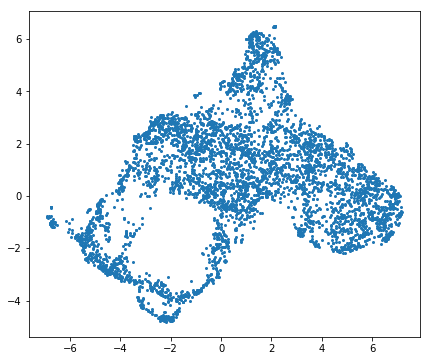

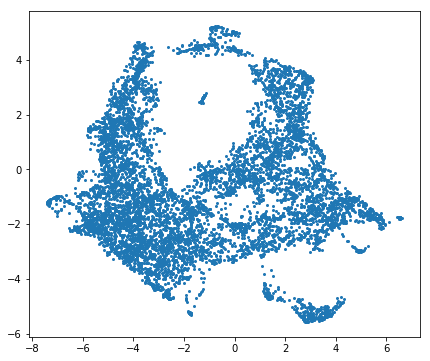

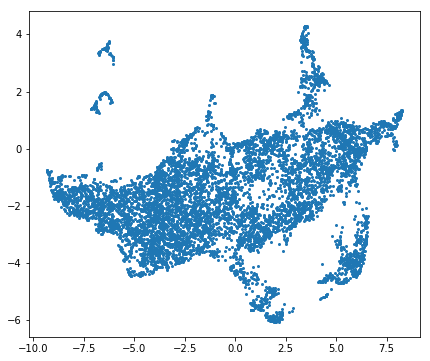

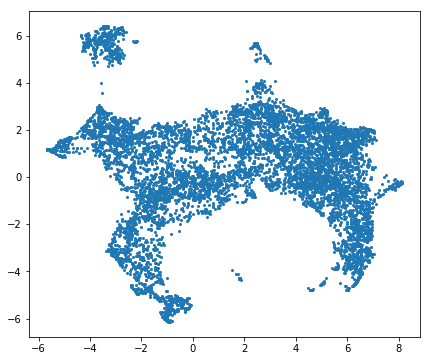

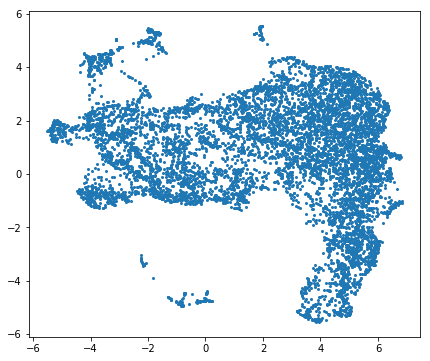

In [23]:
for embedding, file_ in zip(dl_fc_embedding_list, bed_list):
    print(file_)
    plot_embedding_2d(embedding)

In [26]:
dl_conv_SSIndex_list = []
for data in dl_conv_data_list:
    N = np.shape(data)[0]
    SubsetInds,gains = selectSubset( data, n = N, distance = 'corr' )
    dl_conv_SSIndex_list.append(SubsetInds)

In [27]:
dl_fc_SSIndex_list = []
for data in dl_fc_data_list:
    N = np.shape(data)[0]
    SubsetInds,gains = selectSubset( data, n = N, distance = 'corr' )
    dl_fc_SSIndex_list.append(SubsetInds)

W0708 23:52:25.290444 140492965267264 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0708 23:52:25.304633 140492965267264 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0708 23:52:25.322088 140492965267264 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all 

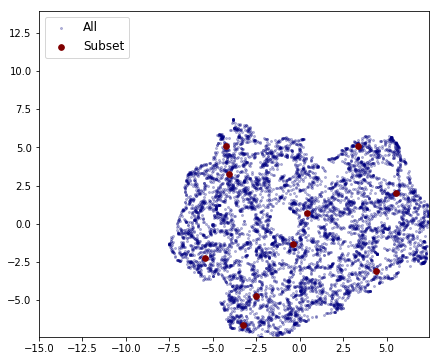

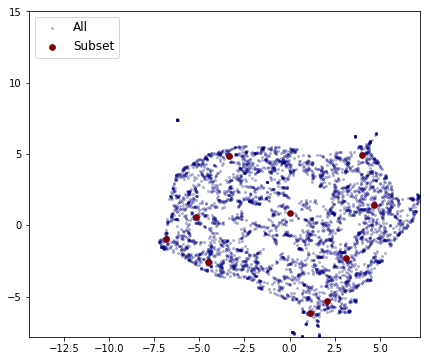

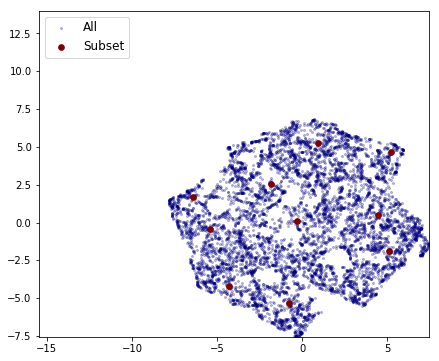

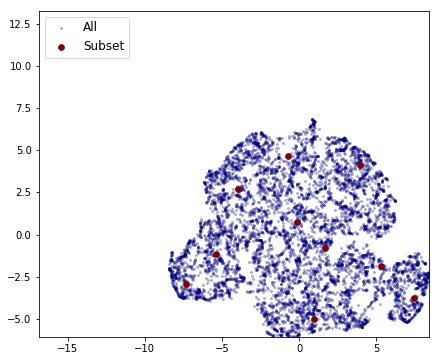

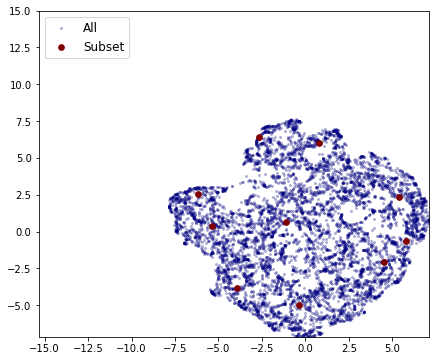

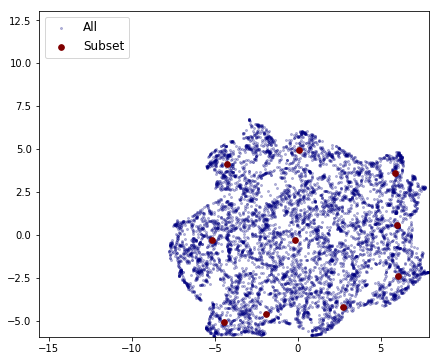

In [29]:
ss_size = 10
size_dict = { 'Subset' : 32, 'All' : 4 }
alpha_dict = { 'Subset' : 1, 'All' : 0.25 }

for SSIndex, embedding in zip (dl_conv_SSIndex_list,dl_conv_embedding_list) :
    num_labels, label_dict = makeGeneralAnnotation ( [SSIndex[0:ss_size]], 
        ['Subset'], k = np.shape(embedding)[0] )
    plot_embedding_2d(embedding, num_labels, label_dict, s_dict = size_dict, a_dict = alpha_dict  )

W0708 23:52:26.836500 140492965267264 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0708 23:52:26.850494 140492965267264 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0708 23:52:26.867711 140492965267264 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all 

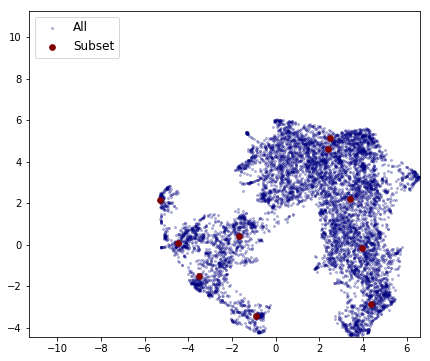

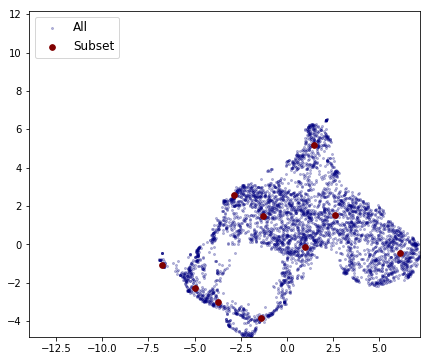

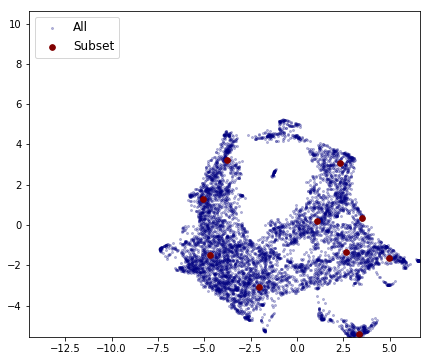

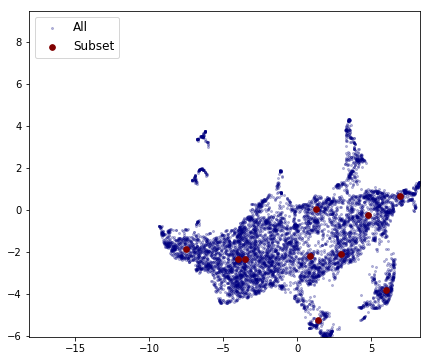

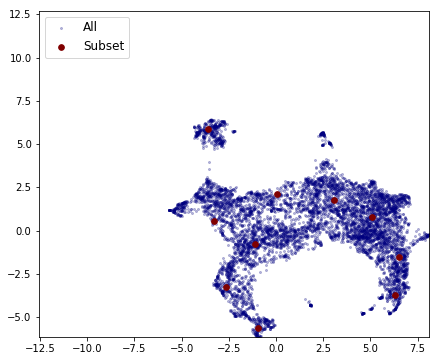

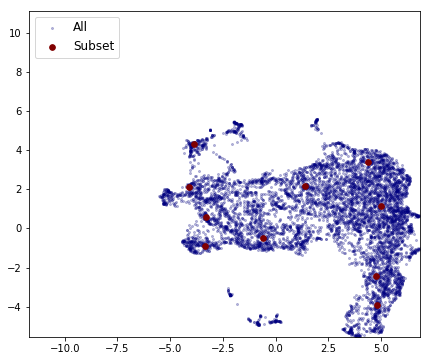

In [30]:
ss_size = 10
size_dict = { 'Subset' : 32, 'All' : 4 }
alpha_dict = { 'Subset' : 1, 'All' : 0.25 }

for SSIndex, embedding in zip (dl_fc_SSIndex_list,dl_fc_embedding_list) :
    num_labels, label_dict = makeGeneralAnnotation ( [SSIndex[0:ss_size]], 
        ['Subset'], k = np.shape(embedding)[0] )
    plot_embedding_2d(embedding, num_labels, label_dict, s_dict = size_dict, a_dict = alpha_dict  )